# Project proposal

---

Group name: John Anderson Torres Mosquera

---


## Introduction

The introduction section includes

-   an introduction to the subject matter you're investigating
-   the motivation for your research question (citing any relevant literature)
-   the general research question you wish to explore
-   your hypotheses regarding the research question of interest.

-------

## Inbound Logistics Forecasting Benchmark

### Introduction

The problem at hand refers to forecasting the inbound material volume (in tons) on monthly basis for the next 4 months for an international automotive company. 

The motivation behind that was the lack of synchronization between suppliers and freight forwarders systems, causing over- or under-capacity planning whenever a plant’s material demands change abruptly, leading to higher logistics transportation costs. 

I published a paper last year about this system, as a result of a research on inbound forecasting systems that I started in 2018. It can be found here [Forecasting System for Inbound Logistics Material Flows at an International Automotive Company](https://www.mdpi.com/2673-4591/39/1/75). Howerver this codebase was written in R using the forecasting package [forecast](https://cran.r-project.org/package=forecast) by Robert Hyndman and George Athanasopoulos in their book [Forecasting at Scale](https://otexts.com/fpp3/). It included algorithms like SARIMA, Exponential Smoothing, Multilayer Neural Networks, Prophet and Vector Autoregression. At that point in time the python packages for timeseries forecasting were not as good as R's. However, the python ecosystem for forecasting has grown a lot in the recent years. There are Python packages like [nitxla](https://nixtlaverse.nixtla.io/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/Python-API.html), [catboost](https://catboost.ai/), as well as LLM forecasting models like [chronos](https://huggingface.co/amazon/chronos-t5-large) that offer many additional functionalities to leverage the use of new algorithms. 

In M5 Competition Results [link](https://www.sciencedirect.com/science/article/pii/S0169207021001874) was demonstrated that boosted tree models can perform better than traditional statistical and methods as wel as Deep Learning Forecasting methods. This will be something we will explore along this project. 

Additionally, I want to use the historical covid numbers from the [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/covid-19/data) to evaluate the influence of this variable in the forecasting accuracy. This is something that has not been explored in the research yet.

### Research question

Which new methods can be used to improve the forecasting accuracy for the Inbound Logistics Volume of an International Automotive Company?

The idea is to create a forecasting system which is accurate and robust to adapt for outliers and unexpected events( e.g. COVID-19). To evaluate the forecast accuracy the `MAE (Mean Absolute Error)` and `SMAPE (Symmetric Mean Absolute Error)` will be used. This will allow us to care about the fact that in some months the transportation volume could have been 0. 

The test timeframes are: 
- Jan 2022 - Apr 2022
- May 2022 - Aug 2022
- Jul 2022 - Oct 2022

This means that models tested in each frame can only be trained with data prior to that frame to avoid data leakage. 

One of the main Business KPI's to track forecast accuracy will be how many timeseries are in a particular `SMAPE` range, for that we will use the following intervals: 

- 0% to 10%
- 10 to 20%
- 20 to 30%
- 30 to 40%
- greater than 40%


The business experts are particularly interested in having a forecating systems for which most of the timeseries have a `SMAPE` of less or equal than 20%.

### Hypothesis

There are new forecasting methods which can deliver better accuracy than traditional statistical methods.


## Data description

In this section, you will describe the data set you wish to explore. This includes

-   description of the observations in the data set,
-   description of how the data was originally collected (not how you found the data but how the original curator of the data collected it).

----------

There are two dataset, one containing the historical volume data, another one containing the production data. In total there are:

- 624  inbound logistics Provider-Plant connections
- 18  plants
- 38  Providers

The historical transport volume data contains data since 2014-01-01 until 2022-10-01.
The historical production data contains data since 2014-01-01 until 2023-12-01. All data until October 2022 is actual produced values, the rest are planning values.

The two input data sources for this project are:

- **Inbound_Volume_Data.csv** contains the historical transported material volume since January 2014 until October 2022 on monthly basis. This data comes from the Logistics Parts Mangement System. 
    - **Timestamp**: Monthly data of the format YYYY/MM.
    - **Provider**: Logistics Service Provider.
    - **Plant**: Assembly Plant. 
    - **Actual Vol [Kg]**: Actual transported volume from Provider to Plant in kg. 
    - **Expected Vol [Kg]**: Expected transported volume from Provider to Plant in kg. $^1$
- **production_data.csv** contains the historical production levels of all the european plants in number of vehicles per month from January 2014 until October 2022. Data after October 2022 refers to planned production values. 
    - **Timestamp**:  Monthly data of the format YYYY/MM.
    - **Plant_X**: Column containing the production level for Plant X.

$^1$ *Expected in this context means the volume value which the internal ERP system would calculate. That means, given the number of units in the call-off order and using the weights of the parts, the total expected weight of a delivery can be calculated. However, as mentioned before, due to the sync issue, the delivered volume and expected volume would differ.*

Additionally, I will explore the Covid 19 cases data: 

- **Covid-19_cases_age_specific.csv**: This data file contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population by age group, week and country. Each row contains the corresponding data for a certain week and country. The file is updated weekly. [source](https://www.ecdc.europa.eu/en/publications-data/covid-19-data-14-day-age-notification-rate-new-cases). The Covid data ranges from 2020-01-06 until 2023-11-20.
    - **country**: Country name
    - **country_code**: cuontry code
    - **year_week**: YYYY-WW data
    - **age_group**: age group
    - **new_cases**: new covid cases
    - **population**: population 
    - **rate_14_day_per_100k**: covid rate per 100.000 inhabitants
    - **source**: Covid source type

The **Inbound_Volume_Data** and **production_data** were obtained from the ERP System of the company and were annonymized for research purposes. The Covid **Covid-19_cases_age_specific.csv** data is available on the website of the European Centre for Disease Prevention and Control.


## Analysis approach

In this section, you will provide a brief overview of your analysis approach. This includes:

-   Description of the response variable.
-   Visualization and summary statistics for the response variable.
-   List of variables that will be considered as predictors
-   Your model type (what kind of model(s) will you use ... e.g. linear regression)

### Response Variable 

The response variable is the number of monthly transported Kg ot material volume from any Provider X to any Plant Y. This is available in the column `Actual Vol [Kg]`.

### Analysis Inbound Volume Data and Response Variable

In [48]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re


In [49]:
df_vol = pd.read_csv("../data/raw/inbound_volume_data.csv", index_col=0)
df_vol["Year"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_vol["Month"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_vol["Timestamp"] = df_vol[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)
# Create Timeseries Key
df_vol["ts_key"] = df_vol[["Provider", "Plant"]].apply(
    lambda x: x["Provider"] + "-" + x["Plant"], axis=1
)

In [50]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
0,2015-07-01,Provider_1,Plant_1,19096,20298,2015,7,Provider_1-Plant_1
1,2015-08-01,Provider_1,Plant_1,187139,189973,2015,8,Provider_1-Plant_1
2,2015-09-01,Provider_1,Plant_1,181149,187798,2015,9,Provider_1-Plant_1
3,2015-10-01,Provider_1,Plant_1,202677,202327,2015,10,Provider_1-Plant_1
4,2015-11-01,Provider_1,Plant_1,272902,271765,2015,11,Provider_1-Plant_1


In [51]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          47058 non-null  datetime64[ns]
 1   Provider           47058 non-null  object        
 2   Plant              47058 non-null  object        
 3   Actual Vol [Kg]    47055 non-null  object        
 4   Expected Vol [Kg]  46951 non-null  object        
 5   Year               47058 non-null  int64         
 6   Month              47058 non-null  int64         
 7   ts_key             47058 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.2+ MB


In [52]:
print("The historical transport volume data contains data since", df_vol['Timestamp'].min(), " until ", df_vol['Timestamp'].max())
print("in Total it contains data for", df_vol['ts_key'].nunique(), " inbound logistics Provider-Plant connections")
print("in Total it contains data for", df_vol['Plant'].nunique(), " plants")
print("in Total it contains data for", df_vol['Provider'].nunique(), " Providers")
print("in Total it contains ", df_vol.shape[0], " rows.")
print("in Total it contains ", df_vol.shape[1], " columns.")

The historical transport volume data contains data since 2014-01-01 00:00:00  until  2022-10-01 00:00:00
in Total it contains data for 624  inbound logistics Provider-Plant connections
in Total it contains data for 18  plants
in Total it contains data for 38  Providers
in Total it contains  47058  rows.
in Total it contains  8  columns.


### Data Transformations

In order to visualize the data. First we need to transform the columns `Actual Vol [Kg]` and `Expected Vol [Kg]`, which are in object type to float type.

In [53]:
df_vol["Actual Vol [Kg]"] = (
    df_vol["Actual Vol [Kg]"].str.replace(".", "").astype("float")
)
df_vol["Expected Vol [Kg]"] = df_vol["Expected Vol [Kg]"].str.replace(".", "")
df_vol["Expected Vol [Kg]"] = (
    df_vol["Expected Vol [Kg]"].str.replace(",", ".").astype("float")
)

# We can transform the units to Tons for ease of manipulation and plotting
df_vol["Actual Vol [Tons]"] = np.round(df_vol["Actual Vol [Kg]"] / 1000, 3)
df_vol["Expected Vol [Tons]"] = np.round(df_vol["Expected Vol [Kg]"] / 1000, 3)

In [54]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  object        
 2   Plant                47058 non-null  object        
 3   Actual Vol [Kg]      47055 non-null  float64       
 4   Expected Vol [Kg]    46951 non-null  float64       
 5   Year                 47058 non-null  int64         
 6   Month                47058 non-null  int64         
 7   ts_key               47058 non-null  object        
 8   Actual Vol [Tons]    47055 non-null  float64       
 9   Expected Vol [Tons]  46951 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 3.9+ MB


In order to visualize the timeseries we can create a line plot over the time for the Actual and Expected Vol columns. 

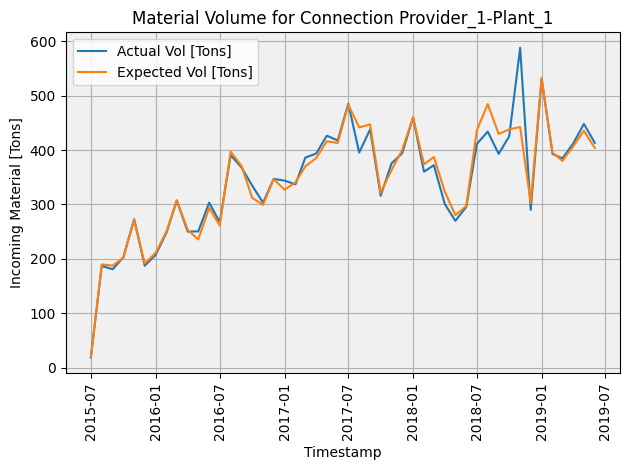

<Figure size 1200x500 with 0 Axes>

In [55]:
ts_key = "Provider_1-Plant_1"
x_axis = "Timestamp"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
_df = df_vol.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]


fig, ax = plt.subplots()

plt.rc("text", usetex=False)
plt.figure(figsize=(12, 5))

ax.plot(x, y1, label=y1_axis)
ax.plot(x, y2, label=y2_axis)
ax.grid(True)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel(x_axis)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Incoming Material [Tons]")
ax.set_title(f"Material Volume for Connection {ts_key}")
ax.legend()

plt.show()

In order to visualize all the timeseries we can create a PDF report which allows us to go through all of them in a more visual manner. 

In [61]:
# We can use the Matplotlib object PdfPages, to create a context, 
# in which each PDF page is generated and then appended to the whole document
pdf_path = "../reports/Inbound_Volume_Charts.pdf"
with PdfPages(pdf_path) as pdf:
    # ts_key = 'Provider_1-Plant_1'
    x_axis = "Timestamp"
    y1_axis = "Actual Vol [Tons]"
    y2_axis = "Expected Vol [Tons]"

    
    for ts_key in df_vol["ts_key"].unique(): #[:10]:
        _df = df_vol.query(f" ts_key == '{ts_key}'")
        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]

        # Turn off interactive mode
        plt.ioff()

        # Activate autolayout so
        # that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True

        fig, ax = plt.subplots()

        plt.rc("text", usetex=False)
        plt.figure(figsize=(12, 5))

        ax.plot(x, y1, label=y1_axis)
        ax.plot(x, y2, label=y2_axis)
        ax.grid(True)
        ax.set_facecolor("#f0f0f0")
        ax.set_xlabel(x_axis)
        ax.tick_params(axis="x", rotation=90)
        ax.set_ylabel("Incoming Material [Tons]")
        ax.set_title(ts_key)
        ax.legend()

        # saves the current figure into a pdf page
        pdf.savefig(fig)
        plt.close(fig)

        del _df

    # Set File Metadata infos
    d = pdf.infodict()
    d["Title"] = "Timeseries Tons"
    d["Author"] = "John Torres"
    d["CreationDate"] = datetime.today()

#### Reponse Variable Description

In [58]:
desc = df_vol.describe()
desc

,Timestamp,Actual Vol [Kg],Expected Vol [Kg],Year,Month,Actual Vol [Tons],Expected Vol [Tons]
count,47058,4.705500e+04,4.695100e+04,47058.000000,47058.000000,47055.000000,46951.000000
mean,2018-05-12 19:43:06.510263552,4.446285e+05,8.292719e+05,2017.912172,6.412002,444.628452,829.271898
min,2014-01-01 00:00:00,1.000000e+00,0.000000e+00,2014.000000,1.000000,0.001000,0.000000
25%,2016-05-01 00:00:00,7.908550e+04,6.820250e+04,2016.000000,3.000000,79.085500,68.202500
50%,2018-06-01 00:00:00,2.480090e+05,2.206440e+05,2018.000000,6.000000,248.009000,220.644000
75%,2020-06-01 00:00:00,5.767820e+05,5.253174e+05,2020.000000,9.000000,576.782000,525.317500
max,2022-10-01 00:00:00,5.880148e+07,5.165009e+08,2022.000000,12.000000,58801.478000,516500.852000
std,NaN,7.162504e+05,9.156459e+06,2.430827,3.421207,716.250404,9156.458726


In [59]:
print("The mean of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['mean'] /1000, 2))
print("The standard deviation of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['std'] /1000, 2))
print("The max value of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['max'] /1000, 2))
print("The min value of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['min'] /1000, 2))

The mean of the material volume in tons among all connections is  444.63
The standard deviation of the material volume in tons among all connections is  716.25
The max value of the material volume in tons among all connections is  58801.48
The min value of the material volume in tons among all connections is  0.0


### Predictor Variables

In Timeseries forecasting it is common to carry out feature engineering using the response variable. For time dependent variables the common approach is to calculate lagged values as well as rolling statistics, e.g., rolling mean and rolling standard deviation. 

For the **historical transport volume** data the predictor variable would be:

- Provider 
- Plant
- Expected Vol (Lagged Values, Rolling Mean, Rolling Std)
- Acutual Vol ( Lagged Values, Rolling Mean, Rolling Std)
- Year
- Month

For the **Covid Data Set** the reponse variables would be. After pivoting and transforming the data in order to match the timestamps values, I would use the following columns as predictors:

- population_per_country
- rate_14_day_per_100k_per_country_per_age

Regarding the **Production Planning Data** it would be used as a smoothing factor to transform the response variable into the so called `Vol/Prod Ratio`. Because the production data and the inbound volume have a natural correlation. We can use this relationship to create a new target variable that will compensate for variations in the inbound volume. This new variable will be called `Vol/Prod Ratio`. 

This approach is possible since the production planning data is always available on monthly basis for the next 12 months in the future. So if we use `Vol/Prod Ratio` instead of `Actual Vol [Kg]` to train the model, we can then easly multiply the forecast values of `Vol/Prod Ratio` with the Production Planning values to get the forecast of `Actual Vol [Kg]`. 

## Data dictionary

*Create a data dictionary for all the variables in your data set. You may fill out the data description table or create your own table with Pandas:*

<br>


| Name  |   Description	| Role   	| Type   	|  Format 	|
|---	|---	        |---    	|---	    |---	|
|   x	|   	 X       |   	X    |   X	    |   X	|
|   	|   	        |   	    |   	    |   	|
|   	|   	        |   	    |   	    |   	|


<br>

- `Role`: response, predictor, ID (ID columns are not used in a model but can help to better understand the data)

- `Type`: nominal, ordinal or numeric

- `Format`: int, float, string, category, date or object